# Analysis of user behavior and results of an A/A/B-testing in a food sales app

The aim of this study is to analyze the behavior of users of a mobile application specializing in the sale of food products, with a focus on analyzing the sales funnel and the results of an A/A/B-testing. Understanding how users interact with the app and progress to a purchase is critical for optimizing conversion rates and improving overall business process efficiency.

The first part of the study introduces the provided data, where each log entry represents a user action or event. The data from the dataset `logs_exp.csv` has the following structure:

- `EventName` — the name of the event;
- `DeviceIDHash` — unique user identifier;
- `EventTimestamp` — time of the event;
- `ExpId` — experiment number: 246 and 247 are control groups, and 248 is the experimental group.

The second part focuses on data preprocessing and preparation for further analysis.

In the third part, we will take a closer look at the events recorded in the logs and describe their quantitative and qualitative characteristics. An exploratory data analysis will be conducted.

In the fourth part of the study, we will examine the sales funnel, which will allow us to identify at which stages users "get stuck" and how many successfully complete a purchase. This analysis will help determine key points of failure and areas for improving the user experience.

The fifth part of the study is dedicated to evaluating the results of an A/A/B-testing conducted to analyze the impact of changes in the app’s interface on user behavior. Specifically, font changes were tested, which raised concerns among managers about potential negative perceptions by users. The experiment involved three user groups: two control groups using the old fonts, and one experimental group with the new fonts. Comparing data between these groups allows us to assess how interface changes affect key metrics and choose the best font option for improving user experience.

Thus, this study provides a comprehensive analysis of user behavior and evaluates the impact of design changes on their interaction with the app, helping to make informed decisions for the further development of the product.

Before starting the research, let's import the libraries and create the functions that we will use in the project.

In [33]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math as mth
import plotly.express as px

In [34]:
def primary_analysis(df):

    print("DataFrame information:")
    print(df.info())
    
    print("\nFirst 5 rows of the DataFrame:")
    print(df.head())
    
    print("\nSummary statistics for numerical columns:")
    print(df.describe())
    
    print("\nNumber of explicit duplicates in the dataset:")
    print(df.duplicated().sum())
    
    print("\nFrequency distributions for categorical columns:")
    for column in df.select_dtypes(include=['object', 'category']).columns:
        print(f"\nColumn '{column}':")
        print(df[column].value_counts())

In [35]:
def z_test_proportions(successes, trials, alpha=0.05):
    # Conversion rates for each group
    p1 = successes[0] / trials[0]
    p2 = successes[1] / trials[1]
    
    # Combined conversion rate
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    
    # Difference of proportions
    difference = p1 - p2
    
    # Standard deviation for the difference of proportions
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    
    # Standard normal distribution
    distr = stats.norm(0, 1)
    
    # Calculation of p-value
    p_value = (1 - distr.cdf(abs(z_value))) * 2  # two-tailed p-value
    
    display('p-value:', p_value)
    
    # Hypothesis test
    if p_value < alpha:
        display('Rejecting the null hypothesis: there is a significant difference between the proportions')
    else:
        display('Failed to reject the null hypothesis, no grounds to consider the proportions different')

## Introduction to the data

Let's load the dataset and explore the general information.

In [36]:
try:
    df = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/logs_exp.csv', sep='\t')

In [37]:
primary_analysis(df)

DataFrame information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
None

First 5 rows of the DataFrame:
                 EventName         DeviceIDHash  EventTimestamp  ExpId
0         MainScreenAppear  4575588528974610257      1564029816    246
1         MainScreenAppear  7416695313311560658      1564053102    246
2  PaymentScreenSuccessful  3518123091307005509      1564054127    248
3         CartScreenAppear  3518123091307005509      1564054127    248
4  PaymentScreenSuccessful  6217807653094995999      1564055322    248

Summary statistics for numerical columns:
       DeviceIDHash  EventTimestamp      

The provided dataframe contains 244,126 records, each representing an event registered in the mobile application. The data includes four columns, and we will slightly adjust the column names in the next section:

- `EventName` (data type: object): The name of the event that occurred in the app. For example, events may be related to the appearance of the main screen, offer screen, cart screen, or successful payment. The most frequent event is MainScreenAppear (appearance of the main screen).

- `DeviceIDHash` (data type: int64): A unique identifier for the user's device. It is used to track the activity of each user.

- `EventTimestamp` (data type: int64): The timestamp of the event, representing the time it was recorded. The provided data type is int64, but we will correct it to datetime64 in the next section.

- `ExpId` (data type: int64): The experiment number to which the event belongs. There are three experiments in the data: 246, 247 (control groups), and 248 (experimental group).

There are no missing values in the data, but 413 explicit duplicates were found, which we will examine later.

The most frequent event is MainScreenAppear, which occurs 119,205 times. The next most frequent is OffersScreenAppear with 46,825 occurrences, followed by CartScreenAppear with 42,731 occurrences, and PaymentScreenSuccessful with 34,313 occurrences. The least frequent event is Tutorial, which occurs only 1,052 times.

Let's proceed with data preprocessing — handling duplicates, renaming columns, adjusting data types, and adding a new column for the date for easier analysis.

## Data preprocessing

Let's start with the column names and change the letters from uppercase to lowercase:

In [38]:
df.columns = [x.lower() for x in df.columns]
display(df.columns)

Index(['eventname', 'deviceidhash', 'eventtimestamp', 'expid'], dtype='object')

Let's convert the EventTimestamp data type to a more suitable datetime64.

In [39]:
df['eventtimestamp'] = pd.to_datetime(df['eventtimestamp'], unit='s')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   eventname       244126 non-null  object        
 1   deviceidhash    244126 non-null  int64         
 2   eventtimestamp  244126 non-null  datetime64[ns]
 3   expid           244126 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 7.5+ MB


Let's work with duplicates and take a look at what these duplicates represent.

In [40]:
all_duplicates = df[df.duplicated(keep=False)]
all_duplicates.head(50)

,eventname,deviceidhash,eventtimestamp,expid
452,MainScreenAppear,5613408041324010552,2019-07-30 08:19:44,248
453,MainScreenAppear,5613408041324010552,2019-07-30 08:19:44,248
2348,CartScreenAppear,1694940645335807244,2019-07-31 21:51:39,248
2350,CartScreenAppear,1694940645335807244,2019-07-31 21:51:39,248
3572,MainScreenAppear,434103746454591587,2019-08-01 02:59:37,248
3573,MainScreenAppear,434103746454591587,2019-08-01 02:59:37,248
4075,MainScreenAppear,3761373764179762633,2019-08-01 03:47:46,247
4076,MainScreenAppear,3761373764179762633,2019-08-01 03:47:46,247
4801,MainScreenAppear,2835328739789306622,2019-08-01 04:44:01,248
4803,MainScreenAppear,2835328739789306622,2019-08-01 04:44:01,248


Based on the analysis of the first 50 rows, we can conclude that some sessions contain duplicates. This can significantly impact funnel analysis and A/A/B testing. Therefore, we will remove the duplicates, keeping only the last occurrences of the repeated rows, and also reset the indexing of the modified dataframe.

In [41]:
df = df.drop_duplicates(keep='last').reset_index()

In [42]:
df.duplicated().sum()

np.int64(0)

As part of the data preprocessing, we will perform the final step - adding a separate column for the date.

In [43]:
df['eventdate'] = df['eventtimestamp'].dt.date
df.head()

,index,eventname,deviceidhash,eventtimestamp,expid,eventdate
0,0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


## Exploratory Data Analysis

As part of the exploratory data analysis, we will answer several questions:

- How many events are there in the log in total?
- How many unique users are there in the log?
- What is the average number of events per user?
- What time period do the data cover?

In [44]:
total_events = df.shape[0]
display(f'Total number of events in the log: {total_events}')
deviceidhash_count = df['deviceidhash'].nunique()
display(f'Total number of users in the log: {deviceidhash_count}')
average_events_per_user = total_events/deviceidhash_count
display(f'On average, there are {average_events_per_user:.2f} events per user.')
min_date = df['eventdate'].min()
max_date = df['eventdate'].max()
display(f'The data was collected from {min_date} to {max_date}')

'Total number of events in the log: 243713'

'Total number of users in the log: 7551'

'On average, there are 32.28 events per user.'

'The data was collected from 2019-07-25 to 2019-08-07'

Now, let's examine how the data changes over time: we will create a bar chart that shows the number of events over time, segmented by groups. Let's check if the data is consistently complete throughout the entire period of the study.

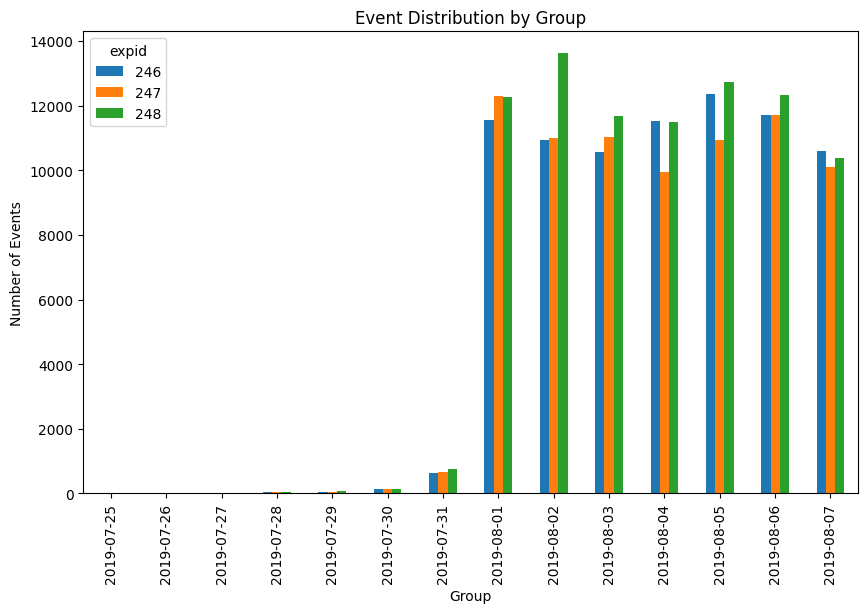

In [45]:
events_per_date = df.pivot_table(index='eventdate', columns='expid', values='index', aggfunc='count', fill_value=0)
events_per_date.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Group')
plt.ylabel('Number of Events')
plt.title('Event Distribution by Group')
plt.show()

Based on the analysis of the number of events, it can be concluded that the data we have covers the period from August 1 to August 7, 2019, inclusive. Therefore, it is necessary to remove the information for July and retain only the data for the first week of August for further analysis in the subsequent chapters of the study. After removing the data, a check should be performed to assess the volume of deleted information and ensure that users are present in all three experimental groups. Finally, it is recommended to create a bar chart to visualize the obtained data.

In [46]:
df['eventdate'] = pd.to_datetime(df['eventdate'])  # Ensure the column is in the correct datetime format
df = df[(df['eventdate'] >= pd.Timestamp('2019-08-01')) & (df['eventdate'] <= pd.Timestamp('2019-08-07'))]
df.info()  # Get summary info of the filtered dataframe

<class 'pandas.core.frame.DataFrame'>
Index: 240887 entries, 2826 to 243712
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   index           240887 non-null  int64         
 1   eventname       240887 non-null  object        
 2   deviceidhash    240887 non-null  int64         
 3   eventtimestamp  240887 non-null  datetime64[ns]
 4   expid           240887 non-null  int64         
 5   eventdate       240887 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 12.9+ MB


Let's calculate how much data we lost after the performed manipulations.

In [47]:
try:
    df_raw = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
except:
    df_raw = pd.read_csv('https://code.s3.yandex.net/datasets/logs_exp.csv', sep='\t')

In [48]:
loss_deviceidhash_absolute = df_raw['DeviceIDHash'].nunique() - df['deviceidhash'].nunique()

# Calculating the relative indicator
loss_deviceidhash_relative = 100 - (df['deviceidhash'].nunique() / df_raw['DeviceIDHash'].nunique() * 100)
loss_deviceidhash_relative = round(loss_deviceidhash_relative, 2)

# Converting to string and adding '%' symbol
loss_deviceidhash_relative = str(loss_deviceidhash_relative) + '%'

display(f'The absolute user loss is: {loss_deviceidhash_absolute}')
display(f'The relative user loss is: {loss_deviceidhash_relative}')

'The absolute user loss is: 17'

'The relative user loss is: 0.23%'

In [49]:
loss_eventname_absolute = df_raw['EventName'].count() - df['eventname'].count()
loss_eventname_relative = (100 - (df['eventname'].count() / df_raw['EventName'].count()) * 100).round(2).astype(str) + '%'

display(f'The absolute event loss is: {loss_eventname_absolute}')
display(f'The relative event loss is: {loss_eventname_relative}')

'The absolute event loss is: 3239'

'The relative event loss is: 1.33%'

By performing this manipulation, we have lost only about one percent of the data. Let's take another look at the bar charts and make sure we have all the necessary data.

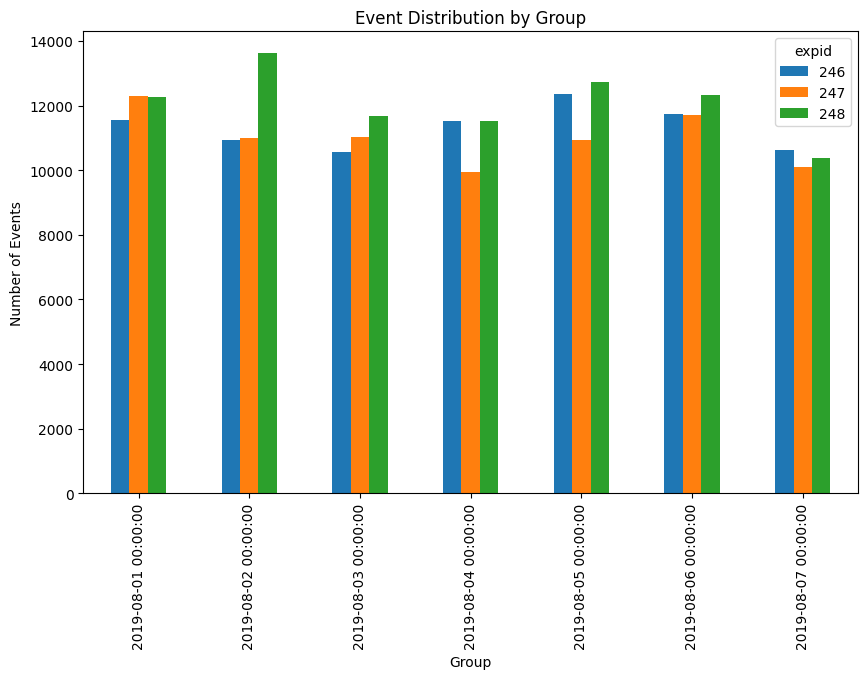

In [50]:
events_per_date = df.pivot_table(index='eventdate', columns='expid', values='index', aggfunc='count', fill_value=0)
events_per_date.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Group')
plt.ylabel('Number of Events')
plt.title('Event Distribution by Group')
plt.show()

## Sales funnel analysis

The data has been processed and is ready for analysis, so let's move on to the sales funnel analysis. First, let's take a look at the events in the logs and how often they occur. We will sort the events by frequency.

In [51]:
df['eventname'].value_counts()

eventname
MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: count, dtype: int64

In the data, we can observe the following events:

1. MainScreenAppear. This event indicates that the user has seen the main screen of the application. The number of such events is 117,328.
2. OffersScreenAppear. This event logs when the user sees the screen with offers (such as discounts or special promotions). The number of such events is 46,333.
3. CartScreenAppear. This event occurs when the user opens the cart screen, where the items added to the cart are displayed. The number of such events is 42,303.
4. PaymentScreenSuccessful. This event logs the successful display of the payment screen when the user has completed the purchase process and proceeds to the 
confirmation screen. The number of such events is 33,918.
5. Tutorial. This event indicates that the user has viewed the tutorial materials or completed an interactive tutorial. The number of such events is 1,005.

Let's calculate how many users performed each of these events. We will sort the events by the number of users. Then, we will calculate the share of users who have performed each event at least once.

In [52]:
user_counts = df.groupby('eventname')['deviceidhash'].nunique().sort_values(ascending=False).reset_index()
user_counts.columns = ['eventname', 'unique_deviceidhash_count']
display("Number of users per event, sorted in descending order:")
user_counts

'Number of users per event, sorted in descending order:'

,eventname,unique_deviceidhash_count
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


In [53]:
total_users = df['deviceidhash'].nunique()
user_counts['user_proportions'] = (user_counts['unique_deviceidhash_count'] / total_users) * 100
display("The proportion of users who performed each event, in percentage:")
user_counts

'The proportion of users who performed each event, in percentage:'

,eventname,unique_deviceidhash_count,user_proportions
0,MainScreenAppear,7419,98.473586
1,OffersScreenAppear,4593,60.963632
2,CartScreenAppear,3734,49.561986
3,PaymentScreenSuccessful,3539,46.973719
4,Tutorial,840,11.149456


Let's assume that the first event in the user journey is MainScreenAppear, as it is the first thing the user sees after opening the app. The last event before the user makes a purchase is PaymentScreenSuccessful. It is logical to assume that before making a purchase, the user should have been in the cart, so the event CartScreenAppear will precede PaymentScreenSuccessful.

The remaining events, OffersScreenAppear and Tutorial, can be placed at intermediate stages of the user journey, as the user may interact with different sections of the app. However, for the purposes of sales funnel analysis, the Tutorial event can be disregarded, as it is not a key stage in the purchasing process.

Based on the above, the sales funnel is structured as follows (from top to bottom):

1. MainScreenAppear
2. OffersScreenAppear
3. CartScreenAppear
4. PaymentScreenSuccessful

Let's calculate the proportion of users who move to the next step in the funnel or the conversion rate for each step, as well as the overall conversion rate, and then describe the results.

In [54]:
user_counts['conversion'] = (user_counts['unique_deviceidhash_count'] / user_counts['unique_deviceidhash_count'][0]) * 100
user_counts['conversion'] = user_counts['conversion'].round(2).astype(str) + '%'
user_counts

,eventname,unique_deviceidhash_count,user_proportions,conversion
0,MainScreenAppear,7419,98.473586,100.0%
1,OffersScreenAppear,4593,60.963632,61.91%
2,CartScreenAppear,3734,49.561986,50.33%
3,PaymentScreenSuccessful,3539,46.973719,47.7%
4,Tutorial,840,11.149456,11.32%


In [55]:
conversion_step = [100]
for i in range(1, len(user_counts)):
    conversion = (user_counts['unique_deviceidhash_count'][i] / user_counts['unique_deviceidhash_count'][i - 1]) * 100
    conversion_step.append(conversion)
user_counts['conversion_per_step'] = conversion_step
user_counts['conversion_per_step'] = user_counts['conversion_per_step'].round(2).astype(str) + '%'
user_counts

,eventname,unique_deviceidhash_count,user_proportions,conversion,conversion_per_step
0,MainScreenAppear,7419,98.473586,100.0%,100.0%
1,OffersScreenAppear,4593,60.963632,61.91%,61.91%
2,CartScreenAppear,3734,49.561986,50.33%,81.3%
3,PaymentScreenSuccessful,3539,46.973719,47.7%,94.78%
4,Tutorial,840,11.149456,11.32%,23.74%


In [56]:
data = dict(
    number=[user_counts.loc[0, 'unique_deviceidhash_count'], user_counts.loc[1, 'unique_deviceidhash_count'], user_counts.loc[2, 'unique_deviceidhash_count'], user_counts.loc[3, 'unique_deviceidhash_count']],
    stage=[user_counts.loc[0, 'eventname'], user_counts.loc[1, 'eventname'], user_counts.loc[2, 'eventname'], user_counts.loc[3, 'eventname']])
fig = px.funnel(data, x='number', y='stage')
fig.update_layout(title='Funnel', title_x = 0.5)
fig.update_layout(title='Funnel', title_x = 0.5)
fig.show()

Analyzing the table and the graphs above, the following conclusions can be made:

- The largest number of users drops off between the events 'MainScreenAppear' and 'OffersScreenAppear'. The loss is 2,826 users or 38.09%, which indicates potential issues at this stage — perhaps users find the offers unappealing or encounter technical problems.
- The proportion of users who reach from the first to the last event, i.e., complete the entire funnel, is 47.7%, or 3,539 out of 7,419 users complete the payment, which can be characterized as a good conversion rate.
- The conversion at the last step — between 'CartScreenAppear' and 'PaymentScreenSuccessful' — is quite high, meaning that those who reached the payment stage are highly likely to complete the purchase.

The main recommendation is to pay attention to and investigate the drop-off between 'MainScreenAppear' and 'OffersScreenAppear'. To improve conversion, focus on optimizing the transition from the main screen to the offers screen, possibly through more precise targeting of offers or addressing potential technical issues.

## A/A/B-testing analysis

Let's move on to the second stage of the analysis and take a look at the results of the A/A/B test. First, let's take a look at the number of users in each experimental group.

In [57]:
expgroup_counts = df.groupby('expid')['deviceidhash'].nunique().sort_values(ascending=False).reset_index()
expgroup_counts.rename(columns={'deviceidhash': 'total_deviceidhash'}, inplace=True)
expgroup_counts

,expid,total_deviceidhash
0,248,2537
1,247,2513
2,246,2484


- 246 — control group with 2,484 users
- 247 — also a control group with 2,513 users
- 248 — experimental group with 2,537 users

We can observe that users are not evenly distributed among the segments, which creates a risk of obtaining completely incorrect results in the A/B test analysis. Let's check if there are any overlapping users who ended up in multiple groups at once. The reason for this is that during A/B testing, errors can occur in logging and distributing users across groups.

In [58]:
df.groupby('deviceidhash').agg({'expid':'nunique'}).query('expid > 1')['expid'].count()

np.int64(0)

There are no overlapping users. The largest difference in the number of users between the groups is 2%. The risk that this may affect the results of the A/B testing exists, but it is relatively small. We can continue with the work.

Before starting the analysis of the A/B experiment, we will check the correctness of all mechanisms and calculations using an A/A experiment. We will verify if the statistical tests detect any differences between the samples 246 and 247. If the traffic and the tool used for the A/A test are reliable, there should be no differences in the metrics. The number of users in the groups differs by about 1%, and visitors assigned to one of the groups remained in that group until the end of the test, which should contribute to the successful execution of the test.

For this purpose, the best choice is the z-test, as it is used to test hypotheses about the equality of proportions. Since we are dealing with user conversion, the most suitable test for checking the equality of conversions between the two control groups is the Z-test for proportions.

The total number of users in groups 246 and 247 is already known to us.

In [59]:
trials_all_246_247 = np.array([expgroup_counts.loc[2, 'total_deviceidhash'],expgroup_counts.loc[1, 'total_deviceidhash']])

For each of the control groups (246 and 247), we will count the number of users who completed the funnel (i.e., successfully converted).

In [60]:
expgroup_counts_pscreen = df.query('eventname == "PaymentScreenSuccessful"').groupby('expid')['deviceidhash'].nunique().sort_values(ascending=False).reset_index()
expgroup_counts_pscreen.rename(columns={'deviceidhash': 'payment_screen_deviceidhash'}, inplace=True)
expgroup_counts_pscreen

,expid,payment_screen_deviceidhash
0,246,1200
1,248,1181
2,247,1158


In [61]:
successes_buy_246_247 = np.array([expgroup_counts_pscreen.loc[0, 'payment_screen_deviceidhash'],expgroup_counts_pscreen.loc[2, 'payment_screen_deviceidhash']])

- H0 = The proportions of users from control groups 246 and 247 who reached the PaymentScreenSuccessful event are equal.
- H1 = The proportions of users from control groups 246 and 247 who reached the PaymentScreenSuccessful event are different.
- Significance level 𝛼 = 0.05

In [62]:
alpha = 0.05

We substitute the values into the function to test the hypothesis of equality of proportions.

In [63]:
z_test_proportions(successes_buy_246_247, trials_all_246_247, alpha)

'p-value:'

np.float64(0.11456679313141849)

'Failed to reject the null hypothesis, no grounds to consider the proportions different'

The results of the test indicate that the statistical criteria do not find a difference between samples 246 and 247, meaning the A/A test was conducted successfully. However, before analyzing the results of the A/B test, let's check other events as well.

Let's choose the most popular event, MainScreenAppear. We will count the number of users who triggered this event in each of the control groups and check if the difference between the groups is statistically significant.

In [64]:
expgroup_counts_mscreen = df.query('eventname == "MainScreenAppear"').groupby('expid')['deviceidhash'].nunique().sort_values(ascending=False).reset_index()
expgroup_counts_mscreen.rename(columns={'deviceidhash': 'main_screen_deviceidhash'}, inplace=True)
expgroup_counts_mscreen

,expid,main_screen_deviceidhash
0,248,2493
1,247,2476
2,246,2450


In [65]:
successes_mscreen_246_247 = np.array([expgroup_counts_mscreen.loc[2, 'main_screen_deviceidhash'],expgroup_counts_mscreen.loc[1, 'main_screen_deviceidhash']])

- H0 = The proportions of users in control groups 246 and 247 who reached the MainScreenAppear event are the same.
- H1 = The proportions of users in control groups 246 and 247 who reached the MainScreenAppear event are different.
- Significance level 𝛼 = 0.05

In [66]:
z_test_proportions(successes_mscreen_246_247, trials_all_246_247, alpha)

'p-value:'

np.float64(0.7570597232046099)

'Failed to reject the null hypothesis, no grounds to consider the proportions different'

No, the difference between the groups cannot be considered statistically significant – the result is the same as for the payment screen.

Let's do the same for all other events. Can we confidently say that the group division is working correctly?

Let's take the event "OffersScreenAppear".

In [67]:
expgroup_counts_oscreen = df.query('eventname == "OffersScreenAppear"').groupby('expid')['deviceidhash'].nunique().sort_values(ascending=False).reset_index()
expgroup_counts_oscreen.rename(columns={'deviceidhash': 'offers_screen_deviceidhash'}, inplace=True)
expgroup_counts_oscreen

,expid,offers_screen_deviceidhash
0,246,1542
1,248,1531
2,247,1520


In [68]:
successes_oscreen_246_247 = np.array([expgroup_counts_oscreen.loc[0, 'offers_screen_deviceidhash'],expgroup_counts_oscreen.loc[2, 'offers_screen_deviceidhash']])

- H0 = The proportions of users from the control groups 246 and 247 who reached the event "OffersScreenAppear" are the same.
- H1 = The proportions of users from the control groups 246 and 247 who reached the event "OffersScreenAppear" are different.
- Significance level 𝛼 = 0.05

In [69]:
z_test_proportions(successes_oscreen_246_247, trials_all_246_247, alpha)

'p-value:'

np.float64(0.2480954578522181)

'Failed to reject the null hypothesis, no grounds to consider the proportions different'

No, the difference between the groups cannot be considered statistically significant.

Let's take the event "CartScreenAppear"

In [70]:
expgroup_counts_cscreen = df.query('eventname == "CartScreenAppear"').groupby('expid')['deviceidhash'].nunique().sort_values(ascending=False).reset_index()
expgroup_counts_cscreen.rename(columns={'deviceidhash': 'cart_screen_deviceidhash'}, inplace=True)
expgroup_counts_cscreen

,expid,cart_screen_deviceidhash
0,246,1266
1,247,1238
2,248,1230


In [71]:
successes_cscreen_246_247 = np.array([expgroup_counts_cscreen.loc[0, 'cart_screen_deviceidhash'],expgroup_counts_cscreen.loc[1, 'cart_screen_deviceidhash']])

- H0 = The proportions of users from control groups 246 and 247 who reached the event "CartScreenAppear" are the same.
- H1 = The proportions of users from control groups 246 and 247 who reached the event "CartScreenAppear" are different.
- Significance level 𝛼 = 0.05

In [72]:
z_test_proportions(successes_cscreen_246_247, trials_all_246_247, alpha)

'p-value:'

np.float64(0.22883372237997213)

'Failed to reject the null hypothesis, no grounds to consider the proportions different'

The result for all comparisons is the same — there are no statistically significant differences between groups 246 and 247, meaning we can confidently say that the group division is working correctly and move on to A/B testing.









Let's proceed similarly with the group that has the changed font — group 248. We'll compare the results with each of the control groups individually for each event, as well as compare the results with the combined control group. Then, we'll analyze the conclusions from the experiment.

Let's combine the number of users who performed each event in each group into one dataset.

In [73]:
df_ab = expgroup_counts.merge(expgroup_counts_mscreen, on='expid', how='left')\
                        .merge(expgroup_counts_oscreen, on='expid', how='left')\
                        .merge(expgroup_counts_cscreen, on='expid', how='left')\
                        .merge(expgroup_counts_pscreen, on='expid', how='left')
df_ab = df_ab.pivot_table(
    index=None,          
    columns='expid',     
    aggfunc='first'      
)

df_ab = df_ab.reindex(['total_deviceidhash', 'main_screen_deviceidhash', 'offers_screen_deviceidhash', 
                       'cart_screen_deviceidhash', 'payment_screen_deviceidhash'])
df_ab

expid,246,247,248
total_deviceidhash,2484,2513,2537
main_screen_deviceidhash,2450,2476,2493
offers_screen_deviceidhash,1542,1520,1531
cart_screen_deviceidhash,1266,1238,1230
payment_screen_deviceidhash,1200,1158,1181


In [74]:
trials_all_246_248 = np.array([df_ab.iloc[0, 0], df_ab.iloc[0, 2]])
trials_all_247_248 = np.array([df_ab.iloc[0, 1], df_ab.iloc[0, 2]])

In [75]:
successes_mscreen_246_248 = np.array([df_ab.iloc[1, 0], df_ab.iloc[1, 2]])
successes_mscreen_247_248 = np.array([df_ab.iloc[1, 1], df_ab.iloc[1, 2]])

In [76]:
successes_oscreen_246_248 = np.array([df_ab.iloc[2, 0], df_ab.iloc[2, 2]])
successes_oscreen_247_248 = np.array([df_ab.iloc[2, 1], df_ab.iloc[2, 2]])

In [77]:
successes_cscreen_246_248 = np.array([df_ab.iloc[3, 0], df_ab.iloc[3, 2]])
successes_cscreen_247_248 = np.array([df_ab.iloc[3, 1], df_ab.iloc[3, 2]])

In [78]:
successes_pscreen_246_248 = np.array([df_ab.iloc[4, 0], df_ab.iloc[4, 2]])
successes_pscreen_247_248 = np.array([df_ab.iloc[4, 1], df_ab.iloc[4, 2]])

- H0 = The proportions of users from control groups 246 and 248 who reached the event "MainScreenAppear" are the same.
- H1 = The proportions of users from control groups 246 and 248 who reached the event "MainScreenAppear" are different.
- Significance level 𝛼 = 0.05

In [79]:
z_test_proportions(successes_mscreen_246_248, trials_all_246_248, alpha)

'p-value:'

np.float64(0.2949721933554552)

'Failed to reject the null hypothesis, no grounds to consider the proportions different'

- H0 = The proportions of users from control groups 246 and 248 who reached the event "OffersScreenAppear" are the same.
- H1 = The proportions of users from control groups 246 and 248 who reached the event "OffersScreenAppear" are different.
- Significance level 𝛼 = 0.05

In [80]:
z_test_proportions(successes_oscreen_246_248, trials_all_246_248, alpha)

'p-value:'

np.float64(0.20836205402738917)

'Failed to reject the null hypothesis, no grounds to consider the proportions different'

- H0 = The proportions of users from control groups 246 and 248 who reached the event "CartScreenAppear" are the same.
- H1 = The proportions of users from control groups 246 and 248 who reached the event "CartScreenAppear" are different.
- Significance level 𝛼 = 0.05

In [81]:
z_test_proportions(successes_cscreen_246_248, trials_all_246_248, alpha)

'p-value:'

np.float64(0.07842923237520116)

'Failed to reject the null hypothesis, no grounds to consider the proportions different'

- H0 = The proportions of users from control groups 246 and 248 who reached the event "PaymentScreenSuccessful" are the same.
- H1 = The proportions of users from control groups 246 and 248 who reached the event "PaymentScreenSuccessful" are different.
- Significance level 𝛼 = 0.05

In [82]:
z_test_proportions(successes_pscreen_246_248, trials_all_246_248, alpha)

'p-value:'

np.float64(0.2122553275697796)

'Failed to reject the null hypothesis, no grounds to consider the proportions different'

- H0 = The proportions of users from control groups 247 and 248 who reached the event "MainScreenAppear" are the same.
- H1 = The proportions of users from control groups 247 and 248 who reached the event "MainScreenAppear" are different.
- Significance level 𝛼 = 0.05

In [83]:
z_test_proportions(successes_mscreen_247_248, trials_all_247_248, alpha)

'p-value:'

np.float64(0.4587053616621515)

'Failed to reject the null hypothesis, no grounds to consider the proportions different'

- H0 = The proportions of users from control groups 247 and 248 who reached the event "OffersScreenAppear" are the same.
- H1 = The proportions of users from control groups 247 and 248 who reached the event "OffersScreenAppear" are different.
- Significance level 𝛼 = 0.05

In [84]:
z_test_proportions(successes_oscreen_247_248 , trials_all_247_248, alpha)

'p-value:'

np.float64(0.9197817830592261)

'Failed to reject the null hypothesis, no grounds to consider the proportions different'

- H0 = The proportions of users from control groups 247 and 248 who reached the event "CartScreenAppear" are the same.
- H1 = The proportions of users from control groups 247 and 248 who reached the event "CartScreenAppear" are different.
- Significance level 𝛼 = 0.05

In [85]:
z_test_proportions(successes_cscreen_247_248 , trials_all_247_248, alpha)

'p-value:'

np.float64(0.5786197879539783)

'Failed to reject the null hypothesis, no grounds to consider the proportions different'

- H0 = The proportions of users from control groups 247 and 248 who reached the event "PaymentScreenSuccessful" are the same.
- H1 = The proportions of users from control groups 247 and 248 who reached the event "PaymentScreenSuccessful" are different.
- Significance level 𝛼 = 0.05

In [86]:
z_test_proportions(successes_pscreen_247_248, trials_all_247_248, alpha)

'p-value:'

np.float64(0.7373415053803964)

'Failed to reject the null hypothesis, no grounds to consider the proportions different'


Comparing the results with each of the control groups for each event, we can conclude that there is no reason to consider the proportions different. This indicates that the font change did not have a statistically significant impact.

Now, let's compare the results with the combined control group.

In [87]:
trials_all_246_247_248 = np.array([df_ab.iloc[0, 0]+df_ab.iloc[0, 1],df_ab.iloc[0, 2]]) 

In [88]:
successes_mscreen_246_247_248 = np.array([df_ab.iloc[1, 0]+df_ab.iloc[1, 1],df_ab.iloc[1, 2]]) 

In [89]:
successes_oscreen_246_247_248 = np.array([df_ab.iloc[2, 0]+df_ab.iloc[2, 1],df_ab.iloc[2, 2]]) 

In [90]:
successes_cscreen_246_247_248 = np.array([df_ab.iloc[3, 0]+df_ab.iloc[3, 1],df_ab.iloc[3, 2]]) 

In [91]:
successes_pscreen_246_247_248 = np.array([df_ab.iloc[4, 0]+df_ab.iloc[4, 1],df_ab.iloc[4, 2]]) 

- H0 = The proportions of users from the combined control groups 246+247 and group 248 who reached the event MainScreenAppear are equal.
- H1 = The proportions of users from the combined control groups 246+247 and group 248 who reached the event MainScreenAppear are different.
- Significance level 𝛼 = 0.05

In [92]:
z_test_proportions(successes_mscreen_246_247_248, trials_all_246_247_248, alpha)

'p-value:'

np.float64(0.29424526837179577)

'Failed to reject the null hypothesis, no grounds to consider the proportions different'

- H0 = The proportions of users from the combined control groups 246+247 and group 248 who reached the event OffersScreenAppear are equal.
- H1 = The proportions of users from the combined control groups 246+247 and group 248 who reached the event OffersScreenAppear are different.
- Significance level 𝛼 = 0.05

In [93]:
z_test_proportions(successes_oscreen_246_247_248 , trials_all_246_247_248, alpha)

'p-value:'

np.float64(0.43425549655188256)

'Failed to reject the null hypothesis, no grounds to consider the proportions different'

- H0 = The proportions of users from the combined control groups 246+247 and group 248 who reached the event CartScreenAppear are equal.
- H1 = The proportions of users from the combined control groups 246+247 and group 248 who reached the event CartScreenAppear are different.
- Significance level 𝛼 = 0.05

In [94]:
z_test_proportions(successes_cscreen_246_247_248 , trials_all_246_247_248, alpha)

'p-value:'

np.float64(0.18175875284404386)

'Failed to reject the null hypothesis, no grounds to consider the proportions different'

- H0 = The proportions of users from the combined control groups 246+247 and group 248 who reached the event PaymentScreenSuccessful are equal.
- H1 = The proportions of users from the combined control groups 246+247 and group 248 who reached the event PaymentScreenSuccessful are different.
- Significance level 𝛼 = 0.05

In [95]:
z_test_proportions(successes_pscreen_246_247_248, trials_all_246_247_248, alpha)

'p-value:'

np.float64(0.6004294282308704)

'Failed to reject the null hypothesis, no grounds to consider the proportions different'

Comparing the experimental group with the combined control group, it can be stated that there are no significant differences, indicating that the font change did not have a statistically significant impact.

In statistical tests, a significance level of 0.05 is commonly used, which means there is a 5% probability of erroneously rejecting the null hypothesis when it is true. This is known as a Type I error or false positive, where the test shows a p-value less than the significance level, leading to the incorrect rejection of the null hypothesis (H0) when there is no actual difference between the groups. In our case, we should also consider the possibility of cumulative errors due to multiple testing, known as the Family-Wise Error Rate (FWER).

We conducted 16 tests comparing groups 246 and 247, 246 and 248, 247 and 248, as well as the combined control group and 248. To control the probability of a Type I error, methods for adjusting the significance level, such as the Bonferroni correction or the Holm method, can be applied.

We set the significance level at 0.05 and obtained results where the null hypothesis was not rejected in any of the tests. However, if the significance level had been set at 0.1, the null hypothesis of equal proportions of users from control groups 246 and 248 reaching the CartScreenAppear event would have been rejected, as the p-value for this test was 0.0784.

In the case of choosing a significance level of 0.1 and applying the Bonferroni correction, the new significance level would be 0.1/16 = 0.00625. This indicates that under these conditions, the test would not have led to the rejection of the null hypothesis.

## Сonclusion

In this study, we conducted a comprehensive analysis of user behavior within a mobile food sales application and evaluated the impact of design changes on user interaction with the app. The study included funnel analysis and results from an A/A/B experiment.

The sales funnel in our app is structured as follows:

- MainScreenAppear
- OffersScreenAppear
- CartScreenAppear
- PaymentScreenSuccessful

The funnel analysis showed that:

- The largest user drop-off occurs between the 'MainScreenAppear' and 'OffersScreenAppear' events, where 38.09% of users (2826 out of 7419) are lost. This indicates potential issues at this stage, such as insufficient appeal of offers or technical problems.
- The percentage of users successfully passing through the entire funnel from 'MainScreenAppear' to 'PaymentScreenSuccessful' is 47.7% (3539 out of 7419), which can be considered a good conversion rate.
- The conversion rate at the last stage of the funnel, between 'CartScreenAppear' and 'PaymentScreenSuccessful,' is relatively high, indicating that users who reach the payment stage are likely to complete their purchase.
- It is recommended to focus on optimizing the transition from the main screen to the offers screen to improve conversion, possibly through better targeting of offers or addressing technical issues.

A/A Test Analysis:

- The check of user distribution between control groups 246 and 247 showed that the difference in user numbers is around 1%, which is minimal and does not significantly affect the A/B test results. No overlapping users were found between the groups. The test results also indicated that statistical criteria did not find a difference between samples 246 and 247, meaning the A/A test was conducted successfully. Thus, the group split can be considered correct, allowing us to move on to A/B testing.

A/B Test Analysis:

- Comparison of results between the experimental group using new fonts and the control groups showed that the font change did not have a statistically significant impact on key metrics. No significant differences were found between the groups across all events, suggesting that changes in font design did not have a meaningful effect on user behavior.

In conclusion, the study confirmed that the current design changes did not lead to improvements in key metrics, and the sales funnel requires optimization at the stage between the main screen and the offers screen. These findings will help focus efforts on the most critical aspects of improving the user experience and making informed decisions regarding the further development of the app.